# Lesson - Machine Learning V: Cross Validation
Earlier, we practiced **train/test validation**, a simple technique for testing a machine learning model's accuracy on new data that the model wasn't trained on. In this lesson, we'll focus on more robust techniques.

### Holdout Validation

Firse, we will discuss the holdout validation technique, which involves:

- splitting the full dataset into 2 partitions:
    - a training set
    - a test set
- training the model on the training set,
- using the trained model to predict labels on the test set,
- computing an error metric to understand the model's effectiveness,
- switch the training and test sets and repeat,
- average the errors.

In holdout validation, we usually use a 50/50 split instead of the 75/25 split from train/test validation. This way, we remove the number of observations as a potential source of variation in our model performance.
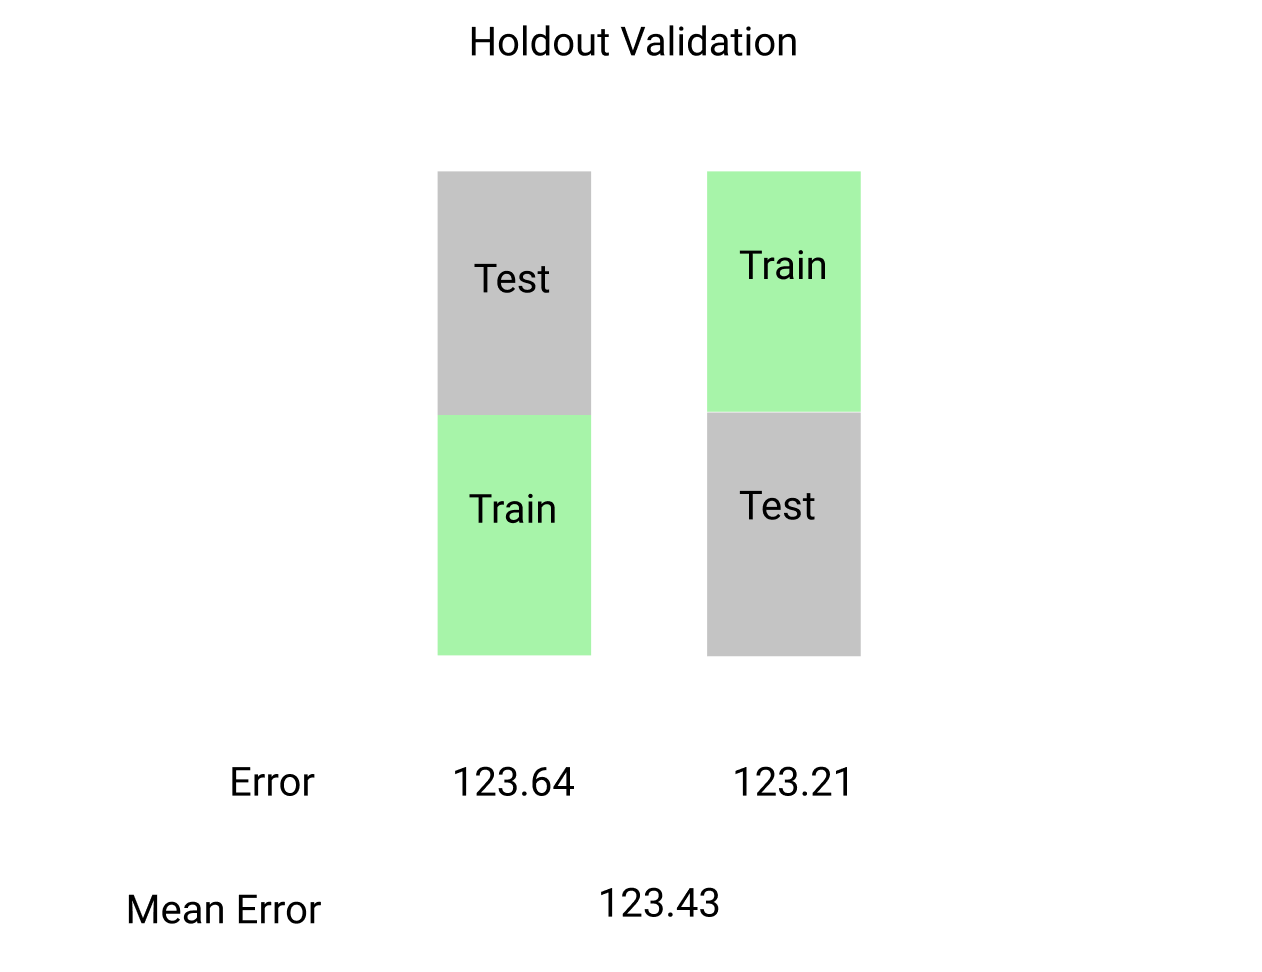

When splitting the data set, we must not forget to set a `copy` of it using `.copy()` to ensure we don't get any unexpected results later on. If we run the code locally in Jupyter Notebook or Jupyter Lab without `.copy()`, we'll notice what is known as a [SettingWithCopy Warning](https://www.dataquest.io/blog/settingwithcopywarning/). This won't prevent our code from running properly, but it's letting us know that whatever operation we're doing is trying to be set on a copy of a slice from a dataframe. To make sure we don't see this warning, we should include `.copy()` whenever performing operations on a dataframe.

Below, we will write a function to facilitate shuffling of the dataset whenever required

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [2]:
dc_listings = pd.read_csv('dc_airbnb.csv')
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')

In [3]:
def shuffle_df(df):
    df = df.loc[np.random.permutation(df.index)]
    df = df.reset_index(drop = True)
    return df
# split the dataframe 50:50
dc_listings = shuffle_df(dc_listings)
split_one = dc_listings.head(int(len(dc_listings.index)*0.5)+1).copy()
split_two = dc_listings.tail(int(len(dc_listings.index)*0.5)).copy()
split_one.info()
split_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862 entries, 0 to 1861
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    1637 non-null   object 
 1   host_acceptance_rate  1544 non-null   object 
 2   host_listings_count   1862 non-null   int64  
 3   accommodates          1862 non-null   int64  
 4   room_type             1862 non-null   object 
 5   bedrooms              1851 non-null   float64
 6   bathrooms             1852 non-null   float64
 7   beds                  1856 non-null   float64
 8   price                 1862 non-null   float64
 9   cleaning_fee          1153 non-null   object 
 10  security_deposit      692 non-null    object 
 11  minimum_nights        1862 non-null   int64  
 12  maximum_nights        1862 non-null   int64  
 13  number_of_reviews     1862 non-null   int64  
 14  latitude              1862 non-null   float64
 15  longitude            

### Models Training
We will use the `KNeighborsRegressor` for training and prediciton with algorithm set to `auto` and `n_neigbors` set to 5 (default values). We will only use one feature i.e. `accommodates` for training, therefore, further formatting of datasets is not required at the moment. Below, we have imported function `knn_values` written earlier for training and prediction and modified it to return `rmse`. We will then caclulate rmse by alternating the training and test datasets. 

In [4]:
def knn_rmse (n, features):
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_squared_error
    mse_values = []
    rmse_values = []
    for i in range(n+1):
        knn = KNeighborsRegressor()
        train_features = train_df[features]
        train_target = train_df['price']
        knn.fit(train_features, train_target)
        predictions = knn.predict(test_df[features])
        y_true = test_df['price']
        y_pred = predictions
        mse = mean_squared_error(y_true, y_pred)
        rmse = mse ** (1/2)
        mse_values.append(mse)
        rmse_values.append(rmse)
    return rmse_values

In [5]:
train_one = split_one
test_one = split_two
train_two = split_two
test_two = split_one

In [6]:
features = ['accommodates']
train_df = train_one
test_df = test_one
iteration_one_rmse = knn_rmse(1, features)[0] # a list is returned

In [7]:
features = ['accommodates']
train_df = train_two
test_df = test_two
iteration_two_rmse = knn_rmse(5, features)[0] # a list is returned

avg_rmse = np.mean([iteration_one_rmse, iteration_two_rmse])
print(iteration_one_rmse, iteration_two_rmse, avg_rmse)

139.52734360372247 117.58469845357816 128.55602102865032


### K-fold Cross-Validation

If we average the two RMSE values above, we get an RMSE value of approximately 128.96. Holdout validation is actually a specific example of a larger class of validation techniques called **k-fold cross-validation**. While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data, both models that are trained only use half the available data. K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation.

The algorithm from k-fold cross validation includes:

- splitting the full dataset into k equal length partitions.
- selecting k-1 partitions as the training set and
- selecting the remaining partition as the test set
- training the model on the training set.
- using the trained model to predict labels on the test fold.
- computing the test fold's error metric.
- repeating all of the above steps k-1 times, until each partition has been used as the test set for an iteration.
- calculating the mean of the k error values.

Holdout validation is essentially a version of k-fold cross validation when k is equal to 2. Generally, 5 or 10 folds is used for k-fold cross-validation. Here's a diagram describing each iteration of 5-fold cross validation:

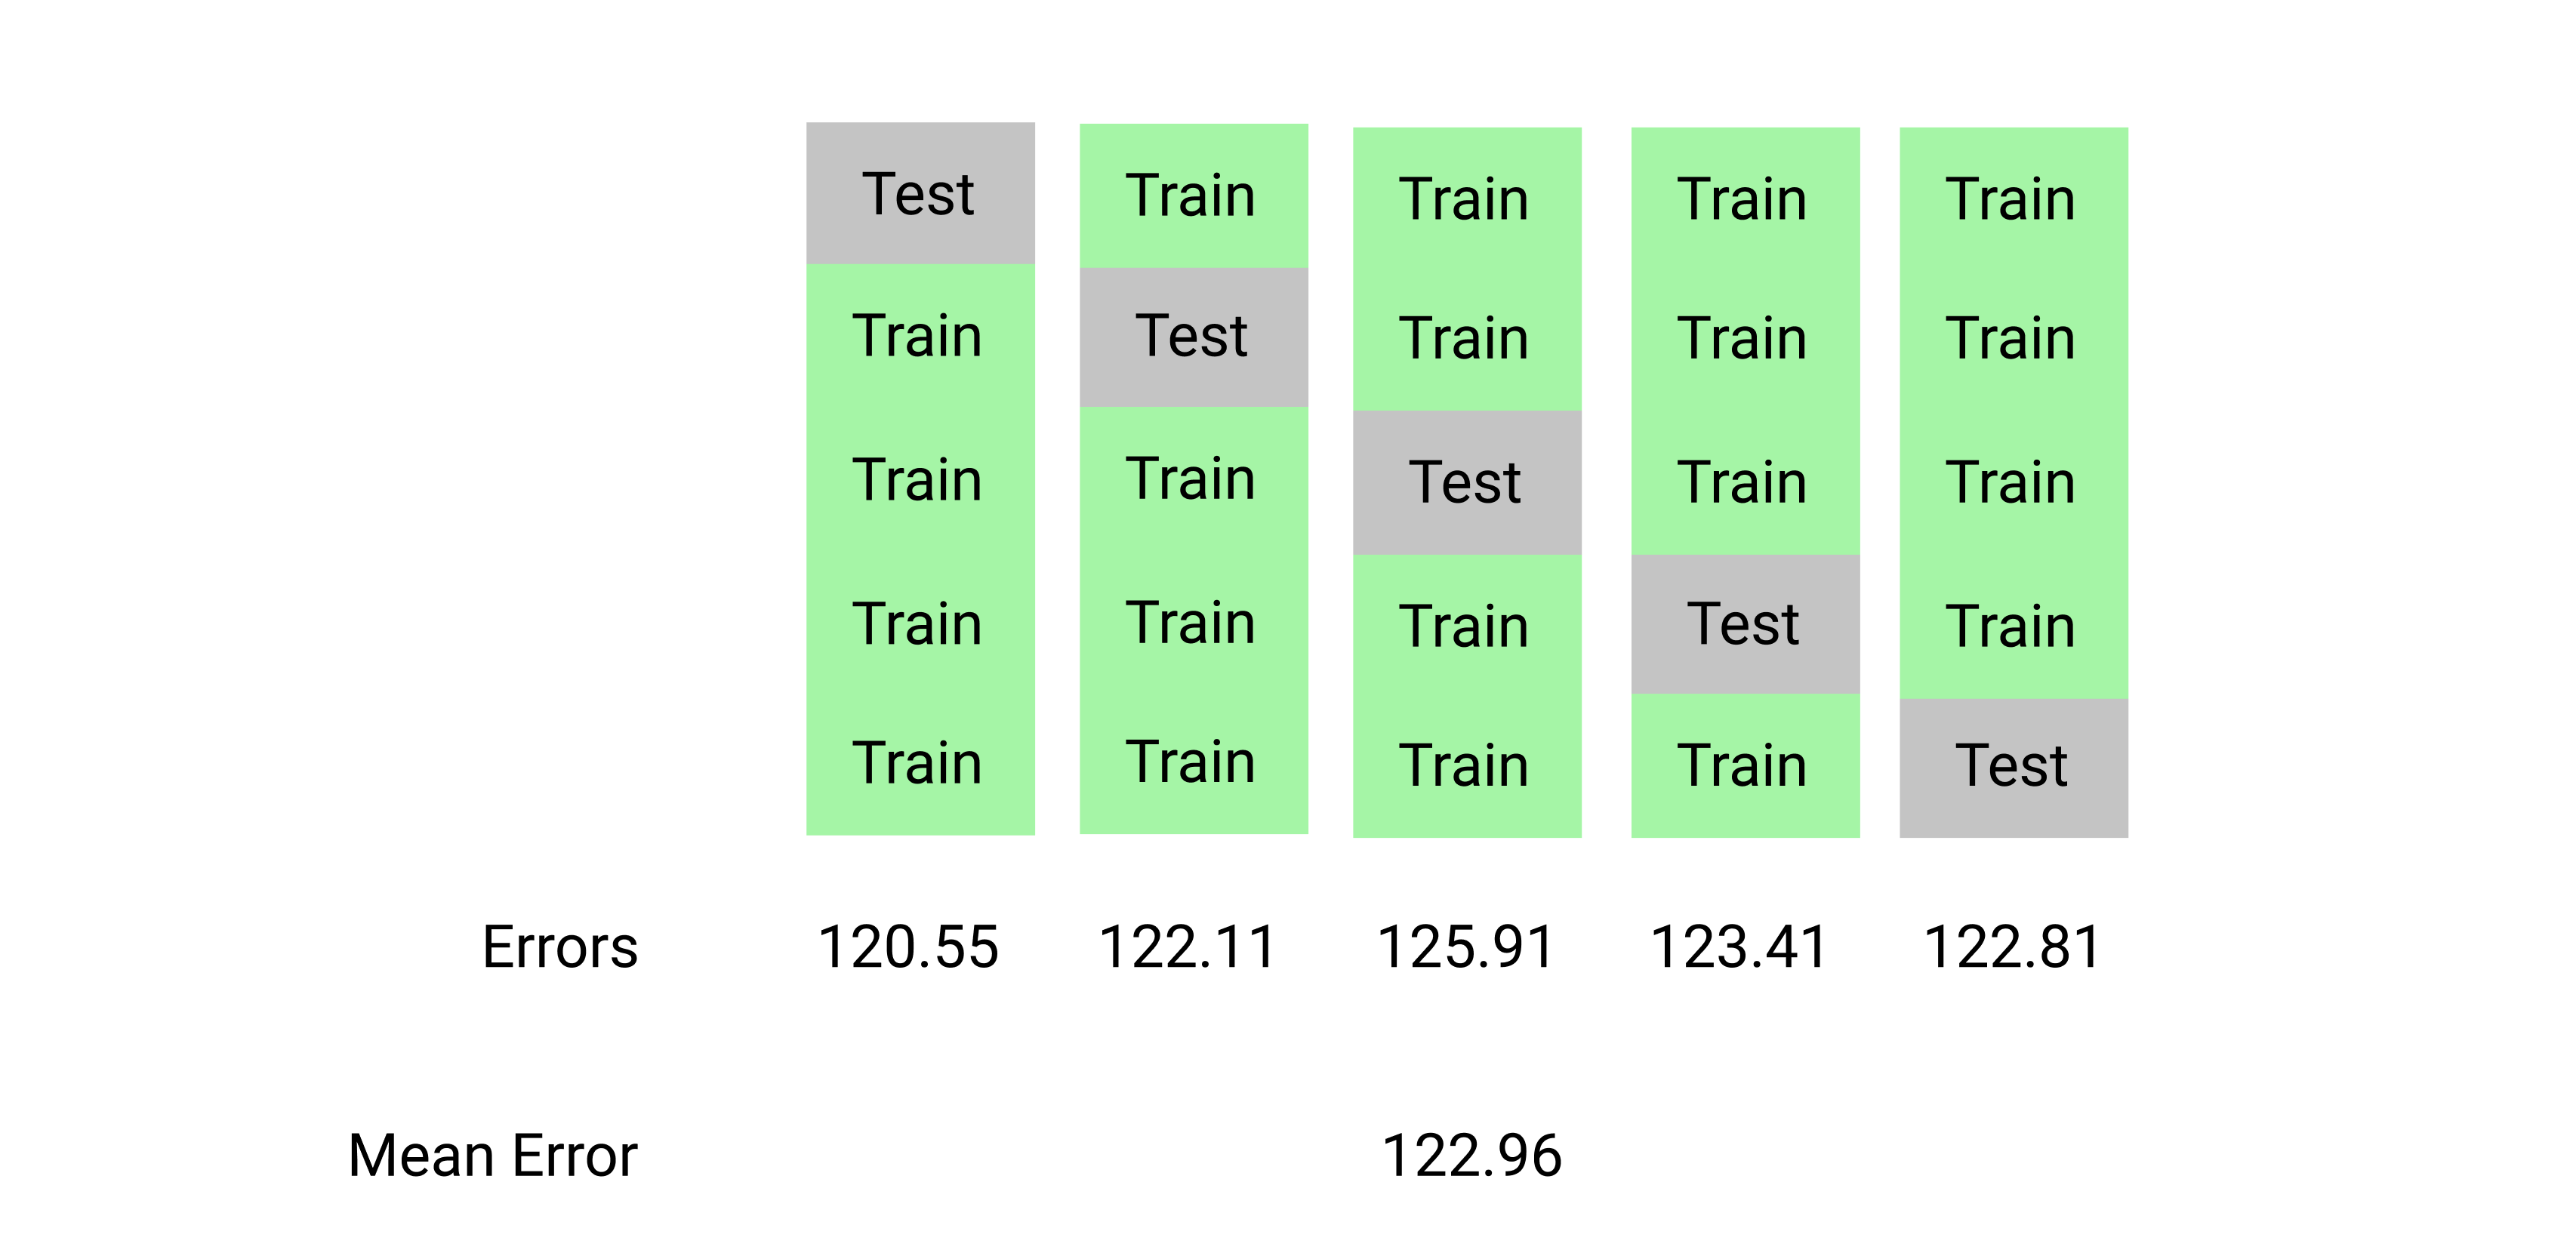

As we increase the number the folds, the number of observations in each fold decreases and the variance of the fold-by-fold errors increases. Below, we will manually partition the data set into 5 folds. Instead of splitting into 5 dataframes, we will add a column that specifies which fold the row belongs to. This way, we can easily select our training set and testing set.

**Exercise**

Add a new column to `dc_listings` named `fold` that contains the fold number each row belongs to:
- Fold 1 should have rows from index 0 up to745, not including 745.
- Fold 2 should have rows from index 745 up to 1490, not including 1490.
- Fold 3 should have rows from index 1490 up to 2234, not including 2234.
- Fold 4 should have rows from index 2234 up to 2978, not including 2978.
- Fold 5 should have rows from index 2978 up to 3723, not including 3723.
- Display the unique value counts for the fold column to confirm that each fold has roughly the same number of elements.
- Display the number of missing values in the fold column to confirm we didn't miss any rows.

We will write a function to accomplish above tase easily

In [19]:
def fold(df, n_folds):
    len_folds = len(df.index)/n_folds
    k_folds = [round(len_folds *i) for i in range(1, n_folds+1)] 
    return k_folds
print(fold(dc_listings, 5)) 

dc_listings.loc[dc_listings.index[0:745], "fold"] = 1
dc_listings.loc[dc_listings.index[745:1490], "fold"] = 2
dc_listings.loc[dc_listings.index[1490:2234], "fold"] = 3
dc_listings.loc[dc_listings.index[2234:2978], "fold"] = 4
dc_listings.loc[dc_listings.index[2978:3723], "fold"] = 5

print(dc_listings['fold'].value_counts())
print("\n Num of missing values: ", dc_listings['fold'].isnull().sum())

[745, 1489, 2234, 2978, 3723]
5.0    745
2.0    745
1.0    745
4.0    744
3.0    744
Name: fold, dtype: int64

 Num of missing values:  0


### First Iteration
We will write a function to perform iterations. However, let's perform the first iteration using the function we are already using.

**Exercise**

- Train a k-nearest neighbors model using the `accommodates` column as the sole feature from folds `2` to `5` as the training set.
- Use the model to make predictions on the test set (accommodates column from fold 1) and assign the predicted labels to labels.
- Calculate the RMSE value by comparing the `price` column with the predicted labels.
- Assign the RMSE value to iteration_one_rmse

In [26]:
features = ['accommodates']
train_df = dc_listings[dc_listings['fold']!=1]
test_df = dc_listings[dc_listings['fold'] == 1]
iteration_one_rmse = knn_rmse(0, features)[0] # a list is returned
iteration_one_rmse

100.2069464028445

In [31]:
def knn_rmse_folds (folds, features):
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_squared_error
    mse_values = []
    rmse_values = []
    for i in range(1, folds+1):
        knn = KNeighborsRegressor()
        train_features = train_df[train_df['fold']!=i][features]
        train_target = train_df[train_df['fold']!=i]['price']
        knn.fit(train_features, train_target)
        predictions = knn.predict(test_df[test_df['fold'] == i][features])
        y_true = test_df[test_df['fold'] == i]['price']
        y_pred = predictions
        mse = mean_squared_error(y_true, y_pred)
        rmse = mse ** (1/2)
        mse_values.append(mse)
        rmse_values.append(rmse)
    return rmse_values

In [32]:
features = ['accommodates']
train_df = dc_listings
test_df = dc_listings
rmses = knn_rmse_folds(5, features)
avg_rmse = np.mean(rmses)
print(rmses, avg_rmse)

[100.2069464028445, 92.46409555304672, 143.58150545831947, 183.92847356267808, 126.15161858843993] 129.26652791306574


### K-fold Cross-Validation using Scikit Learn
While the average RMSE value was approximately 129, the RMSE values ranged from 100 to 183. This large amount of variability between the RMSE values means that we're either using a poor model or a poor evaluation criteria (or a bit of both!). By implementing our own k-fold cross-validation function, we acquired a good understanding of the inner workings of the technique. The function we wrote, however, has many limitations. If we want to now change the number of folds we want to use, we need to make the function more general so it can also handle randomizing the ordering of the rows in the dataframe and splitting into folds.

In machine learning, we're interested in building a good model and accurately understanding how well it will perform. To build a better k-nearest neighbors model, we can change the features it uses or tweak the number of neighbors (a hyperparameter). To accurately understand a model's performance, we can perform k-fold cross validation and select the proper number of folds. We've learned how scikit-learn makes it easy for us to quickly experiment with these different knobs when it comes to building a better model.  Below, we will now use scikit-learn to handle cross-validation as well.

First, we instantiate an instance of the [KFold class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) from sklearn.model_selection:

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits, shuffle=False, random_state=None)

where:

- `n_splits` is the number of folds you want to use,
- `shuffle` is used to toggle shuffling of the ordering of the observations in the dataset,
- `random_state` is used to specify the random seed value if shuffle is set to True.

None of the parameters depend on the data set at all. This is because the KFold class returns an iterator object which we use in conjunction with the `cross_val_score()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), also from sklearn.model_selection. Together, these 2 functions allow us to compactly train and test using k-fold cross validation:

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator, X, Y, scoring=None, cv=None)

where:

- `estimator` is a sklearn model that implements the fit method (e.g. instance of KNeighborsRegressor),
- `X` is the list or 2D array containing the features you want to train on,
- `y` is a list containing the values you want to predict (target column),
- `scoring` is a string describing the scoring criteria (list of accepted values [here](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).
- `cv` describes the number of folds. Here are some examples of accepted values:
    - an instance of the KFold class,
    - an integer representing the number of folds.

**workfolw**

Depending on the scoring criteria we specify, a single total value is returned for each fold. Here's the general workflow for performing k-fold cross-validation using the classes we just described:

- instantiate the scikit-learn model class we want to fit,
- instantiate the `KFold` class and using the parameters to specify the k-fold cross-validation attributes we want,
- use the `cross_val_score()` function to return the scoring metric of interest.

**Exercise**

Create a new instance of the `KFold` class with the following properties:

- `5` folds,
- `shuffle` set to True,
- `random seed` set to 1,
- assigned to the variable `kf`.

Create a new instance of the `KNeighborsRegressor` class and assign to `knn`.

Use the `cross_val_score()` function to perform k-fold cross-validation:

- using the KNeighborsRegressor instance `knn`,
- using the `accommodates` column for training,
- using the `price` column as the target column,
- returning an array of `MSE`values (one value for each fold).
- Assign the resulting list of MSE values to `mses`. Then, take the absolute value followed by the square root of each MSE value. Then, calculate the average of the resulting `RMSE` values and assign to `avg_rmse`.

In [38]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

knn = KNeighborsRegressor()
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

mses = cross_val_score(estimator = knn, X = dc_listings[['accommodates']], 
                                    y = dc_listings['price'], scoring = 'neg_mean_squared_error', cv = kf)
rmses = np.sqrt(np.absolute(mses))
avg_rmse = np.mean(rmses)

print(rmses)
print(avg_rmse)

[128.91042955 134.66335555 124.241451   136.94208826 105.90443222]
126.13235131671006


### Using Different K(fold) Values

Choosing the right `k` value when performing k-fold cross validation is more of an art and less of a science. As we discussed earlier, a `k` value of 2 is really just holdout validation. On the other end, setting `k` equal to `n` (the number of observations in the data set) is known as `leave-one-out cross validation`, or `LOOCV` for short. Through lots of trial and error, data scientists have converged on `10` as the standard `k` value.

In the following code block, we display the results of varying `k` from 3 to 23. For each `k` value, we calculate and display the average RMSE value across all of the folds and the standard deviation of the RMSE values. Across the many different `k` values, it seems like the average RMSE value is around `129`. We'll notice that the standard deviation of the RMSE increases from approximately `8` to over `40` as we increase the number of folds.

In [40]:
from sklearn.model_selection import cross_val_score, KFold

num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]
average_rmse_allfolds = []
average_sd_allfolds = []
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    average_rmse_allfolds.append(avg_rmse)
    average_sd_allfolds.append(std_rmse)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse)) 

3 folds:  avg RMSE:  128.92157491138212 std RMSE:  8.438339429567682
5 folds:  avg RMSE:  126.13235131671006 std RMSE:  11.046179247260696
7 folds:  avg RMSE:  127.26939366901524 std RMSE:  17.947394010664272
9 folds:  avg RMSE:  128.68589355308973 std RMSE:  35.0918565679117
10 folds:  avg RMSE:  129.56994636473428 std RMSE:  22.92983554238743
11 folds:  avg RMSE:  136.93406332653146 std RMSE:  34.96457165826181
13 folds:  avg RMSE:  130.48566860777302 std RMSE:  26.978635545275036
15 folds:  avg RMSE:  126.91037191683066 std RMSE:  33.12198970551178
17 folds:  avg RMSE:  128.22947725828627 std RMSE:  30.193512182488405
19 folds:  avg RMSE:  126.45764948549169 std RMSE:  35.97111942433746
21 folds:  avg RMSE:  125.92936407943824 std RMSE:  35.50268314633024
23 folds:  avg RMSE:  123.12076354480672 std RMSE:  43.12796866909327
[128.92157491138212, 126.13235131671006, 127.26939366901524, 128.68589355308973, 129.56994636473428, 136.93406332653146, 130.48566860777302, 126.91037191683066, 

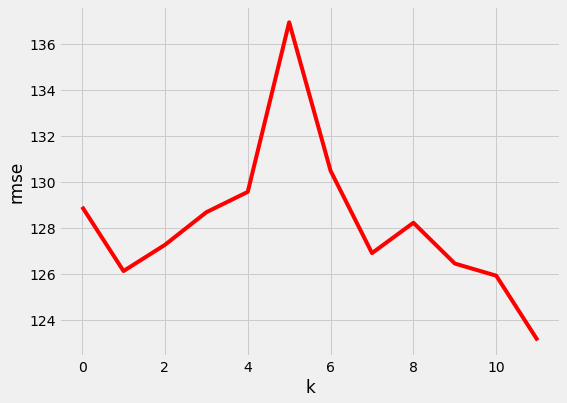

In [44]:
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
plt.plot(average_rmse_allfolds, color = 'red')
plt.xlabel("k") # k is the order of listing not k value
plt.ylabel('rmse')
plt.show()

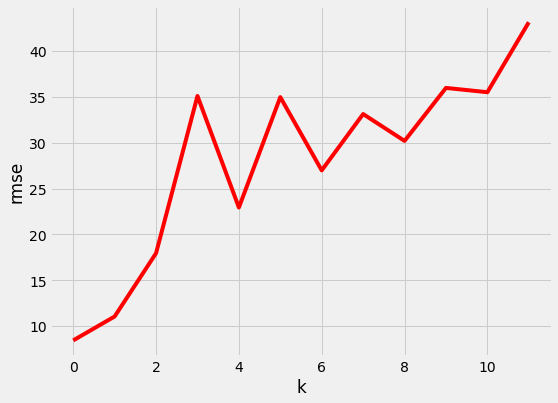

In [45]:
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
plt.plot(average_sd_allfolds, color = 'red')
plt.xlabel("k") # k is the order of listing not k value
plt.ylabel('rmse')
plt.show()

### Bias and Variance

So far, we've been working under the assumption that a lower RMSE always means that a model is more accurate. This isn't the complete picture, unfortunately. A model has two sources of error, bias and variance.

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead us to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's variance while the average RMSE is a proxy for a model's bias. Bias and variance are the 2 observable sources of error in a model that we can indirectly control.

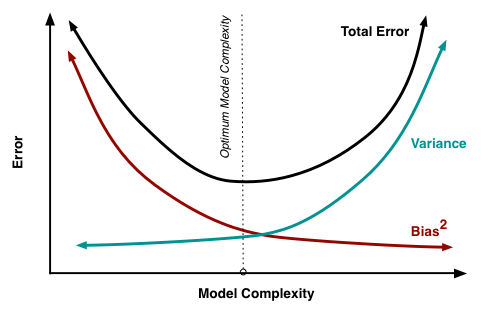

While k-nearest neighbors can make predictions, it isn't a mathematical model. A mathematical model is usually an equation that can exist without the original data, which isn't true with k-nearest neighbors.